## RL for Predictive Maintenance
- V.0.1 30-Oct-2024: Start

### Fixed parameters
1. Sample rate: 25 i.e. about 40 records
2. Gym Env. termination: ```max_episode_steps = MILLING_OPERATIONS_MAX```
3. Rewards: ```R1: +1.0, R2: -4.0, R3: -0.5```
4. Episodes: 30k

## Milling Tool Environment

In [64]:
import gymnasium as gym
from gymnasium import spaces
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

NO_ACTION = 0
REPLACE = 1

class Milling_Tool_Env(gym.Env):
        def __init__(self, max_records=0, env_type = '', rul_threshold=0.0, R1=+1.0, R2=-4.0, R3=-0.5):
            print(f'-- V.0.1 30-Oct-2024: Environment: {env_type} | RUL threshold: {rul_threshold:4.3f} | Records: {max_records}')

            # Initialize
            self.env_type = env_type
            self.R1 = R1
            self.R2 = R2
            self.R3 = R3
            self.reward = 0.0
            self.cummulative_rewards = 0.0

            self.a_rewards = []
            self.a_actions = []
            self.a_action_recommended = []
            self.a_rul = []
            self.a_time_since_last_replacement = []

            self.df = None
            self.current_time_step = 0
            self.max_records = max_records
            self.maintenance_cost = 0.0
            self.replacement_events = 0
            self.time_since_last_replacement = 0
            self.rul_threshold = rul_threshold

            high = np.array(6*[1.0], dtype=np.float32)
            low = np.array(6*[-1.0], dtype=np.float32)
            self.observation_space = spaces.Box(low, high, dtype=np.float32)
            self.action_space = spaces.Discrete(2)

        ## Add tool wear data-set
        def tool_wear_data(self, df):
            self.df = df
            self.max_records = len(df.index)
            print(f'   * Tool-wear data updated: {self.max_records}')

        def _get_observation(self):
            if (self.df is not None):
                if (self.env_type == 'PHM'):
                    obs_values = np.array([
                        self.df.loc[self.current_time_step, 'force_x'],
                        self.df.loc[self.current_time_step, 'force_y'],
                        self.df.loc[self.current_time_step, 'force_z'],
                        self.df.loc[self.current_time_step, 'vibration_x'],
                        self.df.loc[self.current_time_step, 'vibration_y'],
                        self.df.loc[self.current_time_step, 'vibration_z']
                    ], dtype=np.float32)
                else:
                    obs_values = np.array([
                        self.df.loc[self.current_time_step, 'axial_force'],
                        self.df.loc[self.current_time_step, 'force_z'],
                        self.df.loc[self.current_time_step, 'vibration_x'],
                        self.df.loc[self.current_time_step, 'vibration_y'],
                        self.df.loc[self.current_time_step, 'vibration1'],
                        self.df.loc[self.current_time_step, 'vibration2']
                    ], dtype=np.float32)
            else:
                obs_values = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)

            observation = obs_values.flatten()
            return observation

        def _get_auxilliary_info(self):
            if (self.df is not None):
                recommended_action = int(self.df.loc[self.current_time_step, 'ACTION_CODE'])
                rul = float(self.df.loc[self.current_time_step, 'RUL'])
            else:
                recommended_action = 0
                rul = 0.0

            return recommended_action, rul

        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            # self.a_rewards = []
            # self.a_actions = []
            # self.a_action_recommended = []
            # self.a_rul = []

            # Choose the tool wear at a random time (spatial) location from a uniformly random distribution
            # self.current_time_step = np.random.randint(0, int(RANDOM_TOOL_START_OF_LIFE * self.max_records), 1, dtype=int)
            self.current_time_step = 0
            self.reward = 0.0
            self.cummulative_rewards = 0.0

            observation = self._get_observation()
            info = {'reset':'Reset'}
            return observation, info

        ## Step
        def step(self, action):
            terminated = False
            reward = 0.0
            info = {'Step':'-'}
            # Get auxilliary info: current RUL reading (note this is NOT part of the observation) and the expert's recommended action
            recommended_action, self.rul = self._get_auxilliary_info()
            self.maintenance_cost = 0.0

            if self.current_time_step >= self.max_records:
                done = True

            if self.rul > self.rul_threshold:
                reward = self.R1
            else:
                reward = self.R2

            if action == REPLACE:
                # Update time_since_last_replacement
                self.time_since_last_replacement = self.current_time_step
                self.a_time_since_last_replacement.append(self.current_time_step)
                # if self.current_time_step%20 == 0:
                #   print(f'* {self.time_since_last_replacement}')
                # else:
                #   print(f'* {self.time_since_last_replacement}', end = ' ')
                self.current_time_step = 0
                reward = self.R3

            self.reward = reward
            self.cummulative_rewards = self.cummulative_rewards + reward

            # Information arrays
            self.a_rewards.append(reward)
            self.a_actions.append(action)
            self.a_action_recommended.append(recommended_action)
            self.a_rul.append(self.rul)

            if (action != REPLACE) and (self.current_time_step < (self.max_records-1)):
              self.current_time_step += 1

            # Action taken, reward set for that action, now take in next observation
            observation = self._get_observation()


            if self.rul <= self.rul_threshold:
              self.cummulative_rewards = 0.0

            # if self.rul > self.rul_threshold:
            #     print(f'Action>> Expert:{recommended_action:2d} Agent:{action:2d}| RUL: {self.rul:>5.2f} | Reward: {reward:>7.2f} -- CR: {self.cummulative_rewards:>7.2f}' )
            # else:
            #     print(f'*** RUL reached: {self.rul:3.2f} ***')
            #     self.cummulative_rewards = 0.0

            # writer.add_scalar('reward', reward)
            return observation, self.reward, terminated, False, info

## Libraries, Paths, Data-sets

In [65]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# RL libraries
import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from torch.utils.tensorboard import SummaryWriter

# Custom libraries
from utilities import downsample, tool_wear_data

# Data-sets
datasets = {'NUAA_W1':['NUAA_W1_0p229.csv', 0.229], 'NUAA_W3':['NUAA_W3_0p12.csv', 0.12], 'NUAA_W8':['NUAA_W8_0p281.csv', 0.281],
           'PHM_C01':['PHM_C01_0p12.csv', 0.12],  'PHM_C04':['PHM_C04_0p098.csv', 0.098],  'PHM_C06':['PHM_C06_0p13.csv', 0.13]}

# Paths
dt_string = datetime.now().strftime("%d-%b-%Y  %H:%M:%S")
PATH = 'D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance'
DATA_PATH = f'{PATH}/Data/'

## Set-up

In [66]:
# Environment set-up
ENV_TYPE = 'NUAA' # NUAA
TRAINING_DATA = f'{ENV_TYPE}_W8' # C01, C04, C06, W1, W3, W8 
EVALUATION_DATA = f'{ENV_TYPE}_W8'
ADD_NOISE = 5*1e2
SAMPLING_RATE = 25

# RL set-up
EPISODES = 30_000
ALGO = 'PPO'
BATCH_SIZE = 16
EVALUATION_ROUNDS = 20
TENSOR_BOARD = True
PRETRAINED_MODEL = False 

# Set-up data-sets
DATA_FILE = datasets[TRAINING_DATA][0]
WEAR_THRESHOLD = datasets[TRAINING_DATA][1]
TEST_DATA = datasets[EVALUATION_DATA][0]
TEST_WEAR_THRESHOLD = datasets[EVALUATION_DATA][1]

# Paths
DATA_FILE = f'{DATA_PATH}/{DATA_FILE}'
MODEL_FILE = f'{PATH}/models/{TRAINING_DATA}_Agent'
LOG_PATH = f'{PATH}/tensorboard/{TRAINING_DATA}/'

writer = SummaryWriter(LOG_PATH) if TENSOR_BOARD else None 
print(f'Data set: {DATA_FILE}, Threshold: {WEAR_THRESHOLD}')
print(f'Tensorboard logging to {LOG_PATH}')
print(f'Model {MODEL_FILE}')

Data set: D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/Data//NUAA_W8_0p281.csv, Threshold: 0.281
Tensorboard logging to D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/tensorboard/NUAA_W8/
Model D:/ResearchLab/RL_for_PdM/RL_for_Predictive_Maintenance/models/NUAA_W8_Agent


## Tool wear data

- Down-sampling. Input data records: 1008. Sampling rate: 25. Expected rows 40.    Down-sampled to 41 rows.


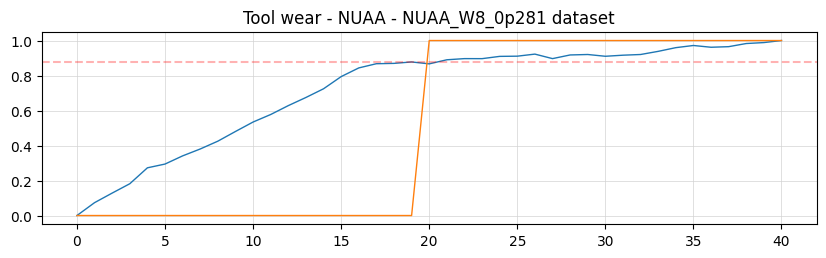

Tool failure RUL threshold at time 19 is 0.133, and WEAR_THRESHOLD 0.281


In [67]:
tool_wear, action_code, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    env_type = ENV_TYPE, data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=True, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)
MILLING_OPERATIONS_MAX = records
rul_threshold_record_train = df_train.loc[df_train['tool_wear'] >= WEAR_THRESHOLD_NORMALIZED].index[0]
rul_threshold_train = df_train.loc[df_train.index[rul_threshold_record_train], 'RUL']
print(f'Tool failure RUL threshold at time {rul_threshold_record_train} is {rul_threshold_train:3.3f}, and WEAR_THRESHOLD {WEAR_THRESHOLD:3.3f}')

## Predictive Maintenance Agent Training

In [68]:
from stable_baselines3.common.monitor import Monitor

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = Milling_Tool_Env,
    max_episode_steps = MILLING_OPERATIONS_MAX,)

mt_env = Monitor(gym.make('custom/MillingToolEnv-v0', max_records=records, env_type=ENV_TYPE, rul_threshold=rul_threshold_train))
# mt_env = gym.make('custom/MillingToolEnv-v0', max_records=records, env_type=ENV_TYPE, rul_threshold=rul_threshold_train)
mt_env.tool_wear_data(df_train)

-- V.0.1 30-Oct-2024: Environment: NUAA | RUL threshold: 0.133 | Records: 41
   * Tool-wear data updated: 41


In [69]:
if ALGO == 'PPO':
  expert_ppo = PPO('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
  expert_ppo.learn(EPISODES)
elif ALGO == 'A2C':
  expert_a2c = A2C('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
  expert_a2c.learn(EPISODES)

In [70]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

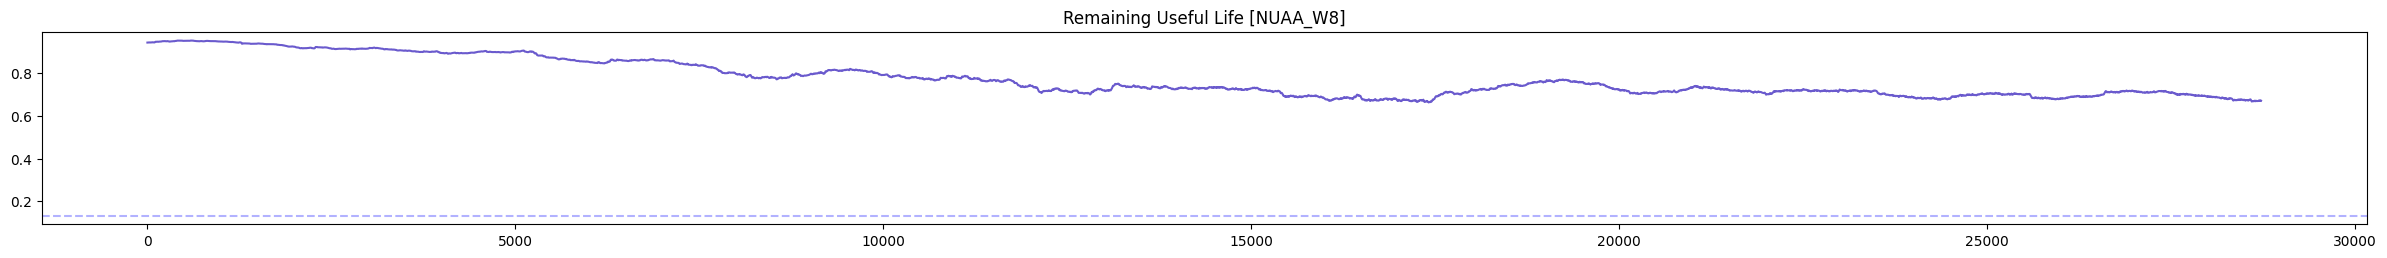

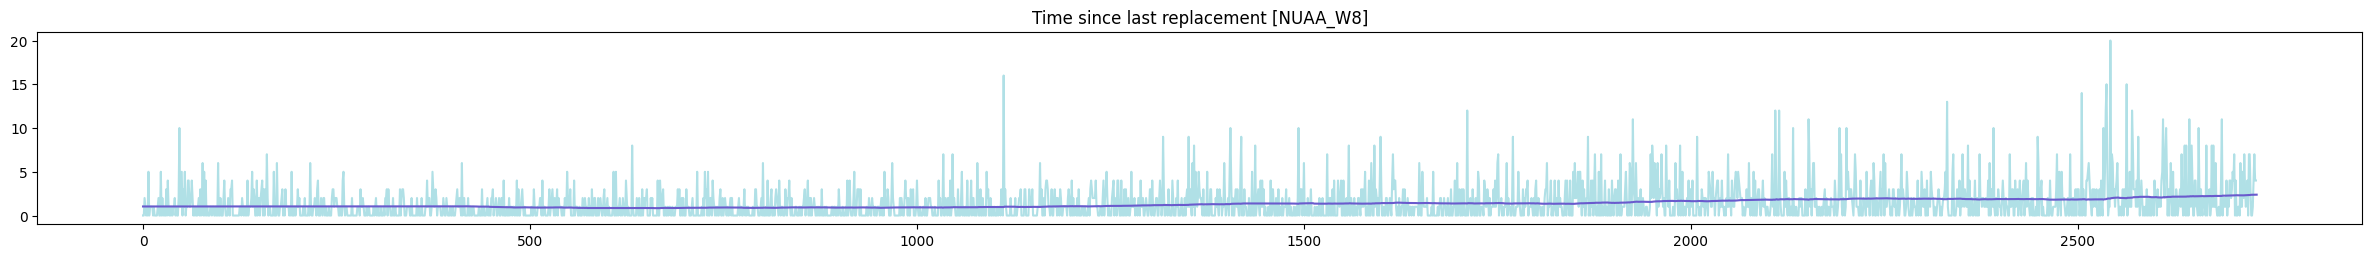

In [71]:
stop_pt = int(1 * len(mt_env.a_rul))
w = 1000
ma_rul = moving_average(mt_env.a_rul[0:stop_pt], w)
# ma_rul = np.pad(ma_rul, pad_width=w, mode='edge')
plt.figure(figsize=(30, 2.5))
# plt.plot(mt_env.a_rul[0:stop_pt], 'powderblue', alpha=0.7)
plt.plot(ma_rul[:-w], 'slateblue')
plt.title(f'Remaining Useful Life [{TRAINING_DATA}]')
plt.axhline(y = rul_threshold_train, color = 'b', linestyle = '--', alpha=0.3)
# plt.axhline(y = WEAR_THRESHOLD_NORMALIZED, color = 'r', linestyle = '--', alpha=0.3)
plt.show()

stop_pt = int(0.5 * len(mt_env.a_time_since_last_replacement))
w = 400
ma_rep_time = moving_average(mt_env.a_time_since_last_replacement[0:stop_pt], w)
ma_rep_time = np.pad(ma_rep_time, pad_width=w, mode='edge')
plt.figure(figsize=(30, 2.5))
plt.plot(mt_env.a_time_since_last_replacement[0:stop_pt], 'powderblue')
plt.plot(ma_rep_time[:-w], 'slateblue')
plt.title(f'Time since last replacement [{TRAINING_DATA}]')
plt.show()

In [90]:
x = mt_env.a_rewards[0:20]
print(x)
print(x[-3:])

[-0.5, -0.5, 1.0, 1.0, -0.5, 1.0, -0.5, -0.5, 1.0, -0.5, -0.5, 1.0, 1.0, 1.0, 1.0, 1.0, -0.5, -0.5, 1.0, -0.5]
[-0.5, 1.0, -0.5]


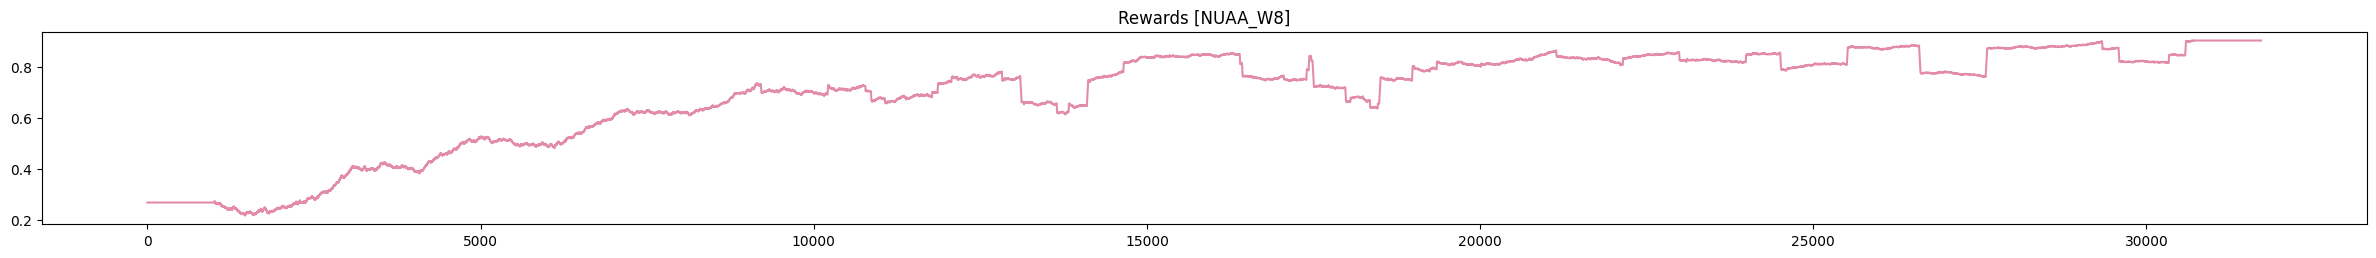

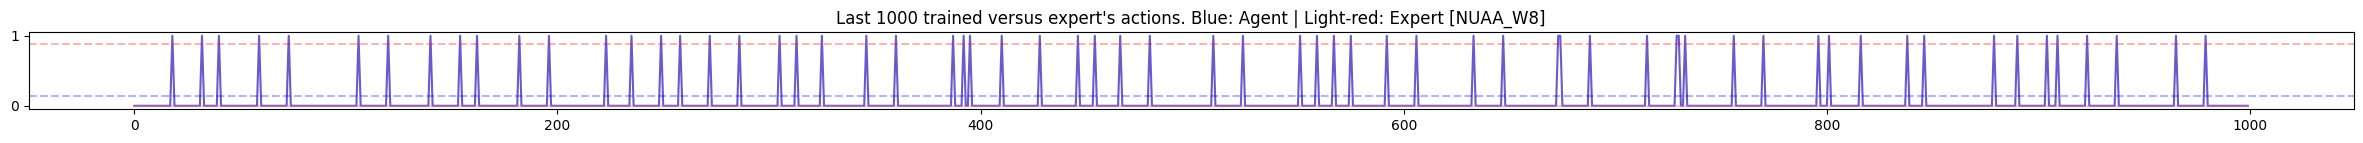

In [92]:
w = 1000
l = EPISODES-w

ma_rewards = moving_average(mt_env.a_rewards, w)
ma_rewards = np.pad(ma_rewards, pad_width=w, mode='edge')

plt.figure(figsize=(30, 2.5))
# plt.plot(mt_env.a_rewards, alpha=0.1)
plt.plot(ma_rewards, 'palevioletred', alpha=0.8)
plt.title(f'Rewards [{TRAINING_DATA}]')
plt.show()

plt.figure(figsize=(30, 1))
plt.plot(mt_env.a_actions[-w:], 'slateblue')
plt.plot(mt_env.a_action_recommended[-w:], 'palevioletred', alpha=0.4)
plt.title(f'Last {w} trained versus expert\'s actions. Blue: Agent | Light-red: Expert [{TRAINING_DATA}]')
plt.axhline(y = rul_threshold_train, color = 'b', linestyle = '--', alpha=0.3)
plt.axhline(y = WEAR_THRESHOLD_NORMALIZED, color = 'r', linestyle = '--', alpha=0.3)
plt.show()